This code is used to compare the operational security performance between LAED and RP under perfect forecasting in 2-generator test system

### Simulation Hyper Parameter Setting

In [1]:
from pyomo.environ import *
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
import json
solver = SolverFactory('gurobi_direct')
solver.options['OutputFlag'] = 0
load_factor = 1.0 # Scale factor for Net Demand
reserve_factor = 0 # For future research use
ramp_factor = 0.1 # Scale factor for resource ramping limit
cost_load = 1e10 # Penalty for load curtailment
cost_curtailed = 0 # Penalty for curtailed renewable   

### System Parameters Data Input

In [2]:
case_name = 'toy_data.dat'
data = DataPortal()
data.load(filename = case_name)

### Time Series Data Input

In [3]:
# Load the JSON file
file_path = 'MISO_Projection.json'
with open(file_path, 'r') as f:
    interpolated_data = json.load(f)

# Scale the Data
# Scale based on Mean Value
# For 2 bus case
#ref_cap = 350
ref_cap = 325
#ref_cap = 300

# Load the JSON file: 2022, 2027, 2032 MISO Load Projection
#Jan_2022_ori = interpolated_data['2022_Jan']
#Aug_2022_ori = interpolated_data['2022_Aug']
#Jan_2027_ori = interpolated_data['2027_Jan']
#Aug_2027_ori = interpolated_data['2027_Aug']
#Jan_2032_ori = interpolated_data['2032_Jan']
Aug_2032_ori = interpolated_data['2032_Aug']

# load_scale_2022 = ref_cap / (sum(Aug_2022_ori.values()) / len(Aug_2022_ori)) 
# load_scale_2027 = ref_cap / (sum(Aug_2027_ori.values()) / len(Aug_2027_ori))
load_scale_2032 = ref_cap / (sum(Aug_2032_ori.values()) / len(Aug_2032_ori))

# Jan_2022 = {int(key): value * load_scale_2022 for key, value in Jan_2022_ori.items()}
# Aug_2022 = {int(key): value * load_scale_2022 for key, value in Aug_2022_ori.items()}
# Jan_2027 = {int(key): value * load_scale_2027 for key, value in Jan_2027_ori.items()}
# Aug_2027 = {int(key): value * load_scale_2027 for key, value in Aug_2027_ori.items()}
# Jan_2032 = {int(key): value * load_scale_2032 for key, value in Jan_2032_ori.items()}
Aug_2032 = {int(key): value * load_scale_2032 for key, value in Aug_2032_ori.items()}
 

### LAED Dispatch Policy Parameter Setting

In [4]:
# Set Look ahead window size
data.data()['N_t'][None] = 13

# Some Constants
N_g = data.data()['N_g'][None]
N_t = data.data()['N_t'][None] # Look ahead window size
cost_init = data.data()['Cost']
N_T = data.data()["N_T"][None]
# Total Simulation Time
N_T = len(Aug_2032_ori) # Total time

## Pyomo Formulation: ED + Ramp Product Reserve

At the beginning, only the (N_t)th ramp product is considered

In [5]:
# Create an abstract model
model_ed = AbstractModel()

# Define sets
model_ed.N_g = Param(within=NonNegativeIntegers) # Number of Generators
model_ed.N_t = Param(within=NonNegativeIntegers) # Window Size
model_ed.G = RangeSet(1, model_ed.N_g)  # Set of Generators
model_ed.T = RangeSet(1, model_ed.N_t)  # Window 

# Define parameters
model_ed.Cost = Param(model_ed.G)
model_ed.Capacity = Param(model_ed.G)
model_ed.Ramp_lim = Param(model_ed.G)
model_ed.Load = Param(model_ed.T)
model_ed.Gen_init = Param(model_ed.G)
model_ed.ramp_single = Param()
model_ed.reserve_single = Param()

# Define variables
model_ed.P = Var(model_ed.G, within=NonNegativeReals)
model_ed.Reserve = Var(model_ed.G, within=NonNegativeReals)
model_ed.rampup = Var(model_ed.G, model_ed.T, within=NonNegativeReals)
model_ed.rampdw = Var(model_ed.G, model_ed.T, within=NonNegativeReals)
model_ed.loadshed = Var(model_ed.T,within=NonNegativeReals)
model_ed.curtailed = Var(model_ed.T,within=NonNegativeReals)

# Objective function: Minimize cost
def objective_rule(model):
    return sum(model.Cost[g] * model.P[g] for g in model.G) + cost_load * sum(model.loadshed[t] for t in model.T) + cost_curtailed * sum(model.curtailed[t] for t in model.T)
model_ed.obj = Objective(rule=objective_rule, sense=minimize)

# Constraints
# Option: Without Considering Curtailment 
def curtailment_rule(model, t):
    return model.curtailed[t] == 0
model_ed.curtailment_constraint = Constraint(model_ed.T, rule=curtailment_rule)

# Capacity constraints
def capacity_rule(model, g):
    return model.P[g] + model.Reserve[g] + model.rampup[g, model.N_t] <= model.Capacity[g]
model_ed.capacity_constraint = Constraint(model_ed.G, rule=capacity_rule)

def capacity_rule_dw(model, g):
    return model.P[g] >= model.rampdw[g, model.N_t]
model_ed.capacitydw_constraint = Constraint(model_ed.G, rule=capacity_rule_dw)

# Power balance constraints
def power_balance_rule(model):
    return sum(model.P[g] for g in model.G) == model.Load[1] - model.loadshed[1] + model.curtailed[1]
model_ed.power_balance_constraint = Constraint(rule=power_balance_rule)

# Ramping constraints for generator
def ramp_down_rule(model, g):
    return -model.Ramp_lim[g] <= model.P[g] - model.Gen_init[g]
model_ed.ramp_down_constraint = Constraint(model_ed.G, rule=ramp_down_rule)

def ramp_up_rule(model, g):
    return model.P[g] - model.Gen_init[g] <= model.Ramp_lim[g]
model_ed.ramp_up_constraint = Constraint(model_ed.G, rule=ramp_up_rule)

# Ramping Reserve constraints
def rampup_reserve_rule(model):
    return sum(model.rampup[g, model.N_t] for g in model.G) >= (model.Load[model.N_t] - model.loadshed[model.N_t] + model.curtailed[model.N_t]) - (model.Load[1] - model.loadshed[1] + model.curtailed[1])
model_ed.rampup_reserve_constraint = Constraint(rule=rampup_reserve_rule) 

def rampdw_reserve_rule(model):
    return sum(model.rampdw[g, model.N_t] for g in model.G) >= (model.Load[1] - model.loadshed[1] + model.curtailed[1]) - (model.Load[model.N_t] - model.loadshed[model.N_t] + model.curtailed[model.N_t])
model_ed.rampdw_reserve_constraint = Constraint(rule=rampdw_reserve_rule) 

# Reserve constraints, Ramp is not part of operation reserve
def reserve_rule(model):
    return sum(model.Reserve[g] for g in model.G) >= reserve_factor * model.Load[1]
model_ed.reserve_constraint = Constraint(rule=reserve_rule)

# Single Generator Reserve Bid Willingness
def reserve_single_rule(model, g):
    return model.Reserve[g]  <= model.reserve_single * model.Capacity[g]
model_ed.reserve_single_constraint = Constraint(model_ed.G, rule=reserve_single_rule)

# Single Generator Ramp up/dw Bid Willingness 
def rampup_single_rule(model, g):
    return model.rampup[g, model.N_t] <= (model.N_t-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampup_single_constraint = Constraint(model_ed.G, rule=rampup_single_rule)

def rampdw_single_rule(model, g):
    return model.rampdw[g, model.N_t] <= (model.N_t-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampdw_single_constraint = Constraint(model_ed.G, rule=rampdw_single_rule)

# Attach dual suffix
model_ed.dual = Suffix(direction=Suffix.IMPORT)

def LMP_calculation(model):
    # Retrieve the results for power output (P) and reserve 
    P_value = np.array([value(model.P[g]) for g in model.G])
    R_value = np.array([value(model.Reserve[g]) for g in model.G])
    rup_value = np.array([value(model.rampup[g, model.N_t]) for g in model.G])
    rdw_value = np.array([value(model.rampdw[g, model.N_t]) for g in model.G])
    loadshed_value = value(model.loadshed[1])
    curtailed_value = value(model.curtailed[1])

    # Retrieve the dual variables (λ) associated with the power balance constraints
    #LMP = np.abs(np.array(model.dual[model.power_balance_constraint]))

    # Our Version
    LMP = np.abs(np.array(model.dual[model.power_balance_constraint])) - np.abs(np.array(model.dual[model.rampup_reserve_constraint])) + np.abs(np.array(model.dual[model.rampdw_reserve_constraint]))

    # Retrieve the dual variables (μ) associated with the reserve constraints
    R_price = np.abs(np.array([model.dual[model.reserve_constraint]]))

    # ramp up price
    rup_price = np.abs(np.array([model.dual[model.rampup_reserve_constraint]]))
    # ramp down price
    rdw_price = np.abs(np.array([model.dual[model.rampdw_reserve_constraint]]))
    
    return P_value, loadshed_value, curtailed_value, LMP, R_value, R_price, rup_value, rup_price, rdw_value, rdw_price

For store and update the data during Rolling Window

In [6]:
def ED_no_errors(data, N_g, N_t, N_T, load_factor, ramp_factor):
    LMP = np.zeros((N_g, N_T - N_t + 1))
    P_LMP = np.zeros((N_g, N_T - N_t + 1))
    R_ED = np.zeros((N_g, N_T - N_t + 1))
    RP_ED = np.zeros((N_g, N_T - N_t + 1))
    rup_ED = np.zeros((N_g, N_T - N_t + 1))
    rupp_Ed = np.zeros((N_g, N_T - N_t + 1))
    rdw_ED = np.zeros((N_g, N_T - N_t + 1))
    rdwp_Ed = np.zeros((N_g, N_T - N_t + 1))
    Shed_ED = np.zeros(N_T - N_t + 1)
    Curt_ED = np.zeros(N_T - N_t + 1)

    # User defined Load and Reserve Level
    load_data = {key: value * load_factor for key, value in data.data()['Load'].items()}
    gen_init = {key: value * load_factor for key, value in data.data()['Gen_init'].items()}
    ramp_data = {key: value * ramp_factor for key, value in data.data()['Ramp_lim'].items()}
    camp_init = data.data()['Capacity']
    cost_init = data.data()['Cost']

    # Create a copy of the data
    data_ed = copy.deepcopy(data)
    data_ed.data()['Load'] = load_data
    data_ed.data()['Gen_init'] = gen_init
    data_ed.data()['Ramp_lim'] = ramp_data
    data_ed.data()['Capacity'] = camp_init
    data_ed.data()['Cost'] = cost_init

    for T0 in range(1, N_T - N_t + 2):
        # Roll the time window
        subset_load_data = {t-T0+1: load_data[t] for t in range(T0, T0 + N_t)} 
        data_ed.data()['Load'] = subset_load_data
        # Update the initial generation for the first time window
        if T0 > 1:
            for i, key in enumerate(data_ed.data()['Gen_init'].keys()):
                data_ed.data()['Gen_init'][key] = P_LMP[i, T0 - 2]
        else:
            data_ed.data()['Gen_init'] = gen_init 

    # We do not update the ramp limit in the energy market, because if might affect the LMP calculation
    # For example, even if a gen did not bid in the ramp reserve market, it might still be dispatched in the energy market
    # The role of ramp reserve market is to ensure the enough ramping capability in the future              
        ed = model_ed.create_instance(data_ed)
        solver.solve(ed, tee=False)
        P_ed, Shed_ed, Curt_ed, LMP_T, R_ed, Rp_ed, rup_ed, rupp_ed, rdw_ed, rdwp_ed = LMP_calculation(ed)
        LMP[:, T0 - 1] = LMP_T*np.ones(N_g)
        P_LMP[:, T0 - 1] = P_ed
        R_ED[:, T0 - 1] = R_ed
        RP_ED[:, T0 - 1] = Rp_ed*np.ones(N_g)
        rup_ED[:, T0 - 1] = rup_ed
        rupp_Ed[:, T0 - 1] = rupp_ed*np.ones(N_g)
        rdw_ED[:, T0 - 1] = rdw_ed
        rdwp_Ed[:, T0 - 1] = rdwp_ed*np.ones(N_g)
        Shed_ED[T0 - 1] = Shed_ed
        Curt_ED[T0 - 1] = Curt_ed

    return P_LMP, Shed_ED, Curt_ED, LMP, R_ED, RP_ED, rup_ED, rupp_Ed, rdw_ED, rdwp_Ed

## Pyomo Formulation: LAED

In [7]:
# Create an abstract model
model_laed = AbstractModel()

# Define sets
model_laed.N_g = Param(within=NonNegativeIntegers) # Number of Generators
model_laed.N_t = Param(within=NonNegativeIntegers) # Window Size
model_laed.N_T = Param(within=NonNegativeIntegers) # Total Time
model_laed.G = RangeSet(1, model_laed.N_g)  # Set of Generators
model_laed.T = RangeSet(1, model_laed.N_t)  # Window 

# Define parameters
model_laed.Cost = Param(model_laed.G)
model_laed.Capacity = Param(model_laed.G)
model_laed.Ramp_lim = Param(model_laed.G)
model_laed.Load = Param(model_laed.T)
model_laed.Gen_init = Param(model_laed.G)
model_laed.reserve_single = Param()


# Define variables
model_laed.P = Var(model_laed.G, model_laed.T, within=NonNegativeReals)
model_laed.Reserve = Var(model_laed.G, model_laed.T, within=NonNegativeReals)
model_laed.loadshed = Var(model_laed.T, within=NonNegativeReals)
model_laed.curtailed = Var(model_laed.T, within=NonNegativeReals)

# Objective function: Minimize cost
def objective_rule(model):
    return sum(model.Cost[g] * sum(model.P[g, t] for t in model.T) for g in model.G) + cost_load * sum(model.loadshed[t] for t in model.T) + cost_curtailed * sum(model.curtailed[t] for t in model.T)
    #return sum(model.Cost[g] * model.P[g, 1] for g in model.G) + cost_load * model.loadshed[1] + cost_curtailed * model.curtailed[1]
model_laed.obj = Objective(rule=objective_rule, sense=minimize)

# Constraints
# Option: Without Considering Curtailment 
# (model_ed.curtailed == 0)
def curtailment_rule(model, t):
    return model.curtailed[t] == 0
model_laed.curtailment_constraint = Constraint(model_laed.T, rule=curtailment_rule)

# Capacity constraints
def capacity_rule(model, g, t):
    return model.P[g, t] + model.Reserve[g, t] <= model.Capacity[g]
model_laed.capacity_constraint = Constraint(model_laed.G, model_laed.T, rule=capacity_rule)

# Power balance constraints
def power_balance_rule(model, t):
    return sum(model.P[g, t] for g in model.G) == model.Load[t] - model.loadshed[t] + model.curtailed[t]
model_laed.power_balance_constraint = Constraint(model_laed.T, rule=power_balance_rule)

# Ramping constraints for generator
def ramp_down_rule(model, g, t):
    if t == min(model.T):
        return -model.Ramp_lim[g]+ model.Gen_init[g] - model.P[g, t] <= 0 
        #return model.P[g, t] >= 0  # No ramping in the first time step
    else:
        return -model.Ramp_lim[g] + model.P[g, t - 1] - model.P[g, t] <= 0 
model_laed.ramp_down_constraint = Constraint(model_laed.G, model_laed.T, rule=ramp_down_rule)

def ramp_up_rule(model, g, t):
    if t == min(model.T):
        return model.P[g, t] - model.Gen_init[g] - model.Ramp_lim[g]<= 0
        #return model.P[g, t] >= 0  # No ramping in the first time step
    else:
        return model.P[g, t] - model.P[g, t - 1] - model.Ramp_lim[g] <= 0 
model_laed.ramp_up_constraint = Constraint(model_laed.G, model_laed.T, rule=ramp_up_rule)

# Reserve constraints, total reserve is reserve_factor of the total load
def reserve_rule(model, t):
    return sum(model.Reserve[g, t] for g in model.G) >= reserve_factor * model.Load[t]
model_laed.reserve_constraint = Constraint(model_laed.T, rule=reserve_rule)

# Single Generator Reserve Bid
def reserve_single_rule(model, g, t):
    return model.Reserve[g, t] <= model.reserve_single * model.Capacity[g]
model_laed.reserve_single_constraint = Constraint(model_laed.G, model_laed.T, rule=reserve_single_rule)

# Attach dual suffix
model_laed.dual = Suffix(direction=Suffix.IMPORT)


# Return both conventional LMP and TLMP
def TLMP_calculation(model, N_g, N_t):
    # Retrieve the results for power output (P) and reserve output (R)
    P_value = np.array([[value(model.P[g, t]) for t in model.T] for g in model.G])
    R_value = np.array([[value(model.Reserve[g, t]) for t in model.T] for g in model.G])
    loadshed_value = np.array([value(model.loadshed[t]) for t in model.T])
    curtailed_value = np.array([value(model.curtailed[t]) for t in model.T])


    # Retrieve the dual variables (λ) associated with the power balance constraints
    # np.abs to gurantee positive value
    la = np.abs(np.array([model.dual[model.power_balance_constraint[t]] for t in model.T]))

    # Retrieve the dual variables (μ) associated with ramping constraints
    # For ramp-down constraints (Note: np.abs to convert Gurobi dual sign)
    mu_down = np.abs(np.array([[model.dual[model.ramp_down_constraint[g, t]] for t in model.T] for g in model.G]))
    #mu_down = 0

    # For ramp-up constraints (Note: np.abs to convert Gurobi dual sign)
    mu_up = np.abs(np.array([[model.dual[model.ramp_up_constraint[g, t]] for t in model.T] for g in model.G]))
    #mu_up =0 

    # Retrieve the dual variables (λ) associated with the reserve constraints
    # np.abs to gurantee positive value
    R_price = np.abs(np.array([model.dual[model.reserve_constraint[t]] for t in model.T]))

    # Initialize TLMP_T matrix
    TLMP_T = np.zeros((N_g, N_t))

    return P_value, loadshed_value, curtailed_value, TLMP_T, la, mu_down, mu_up, R_value, R_price

For store and update the data during Rolling Window

In [8]:
def LAED_No_Errors(data, N_g, N_t, N_T, load_factor, ramp_factor):
    TLMP = np.zeros((N_g, N_T - N_t + 1))
    LLMP = np.zeros((N_g, N_T - N_t + 1))
    P_LAED = np.zeros((N_g, N_T - N_t + 1))
    R_LAED = np.zeros((N_g, N_T - N_t + 1))
    RP_LAED = np.zeros((N_g, N_T - N_t + 1))
    Shed_LAED = np.zeros(N_T - N_t + 1)
    Curt_LAED = np.zeros(N_T - N_t + 1)

    # User defined Load and Reserve Level
    load_data = {key: value * load_factor for key, value in data.data()['Load'].items()}
    gen_init = {key: value * load_factor for key, value in data.data()['Gen_init'].items()}
    ramp_data = {key: value * ramp_factor for key, value in data.data()['Ramp_lim'].items()}
    camp_init = data.data()['Capacity']
    cost_init = data.data()['Cost']

    # Create a copy of the data
    data_laed = copy.deepcopy(data)
    data_laed.data()['Load'] = load_data
    data_laed.data()['Gen_init'] = gen_init
    data_laed.data()['Ramp_lim'] = ramp_data
    data_laed.data()['Capacity'] = camp_init
    data_laed.data()['Cost'] = cost_init


    for T0 in range(1, N_T - N_t + 2):
        # Roll the time window
        subset_load_data = {t-T0+1: load_data[t] for t in range(T0, T0 + N_t)}
        data_laed.data()['Load'] = subset_load_data
        # Update the initial generation for the first time window
        if T0 > 1:
            for i, key in enumerate(data_laed.data()['Gen_init'].keys()):
                data_laed.data()['Gen_init'][key] = P_LAED[i, T0 - 2]
        else:
            data_laed.data()['Gen_init'] = gen_init  
        laed = model_laed.create_instance(data_laed)
        solver.solve(laed, tee=False)
        P_laed, Shed_laed, Curt_laed, TLMP_T, LLMP_T,_,_,R_laed, Rp_laed = TLMP_calculation(laed, N_g, N_t)

        P_LAED[:, T0 - 1] = P_laed[:, 0]
        R_LAED[:, T0 - 1] = R_laed[:, 0]
        TLMP[:, T0 - 1] = TLMP_T[:, 0]
        LLMP[:,T0 - 1] = LLMP_T[0]*np.ones(N_g)
        RP_LAED[:, T0 - 1] = Rp_laed[0]*np.ones(N_g)
        Shed_LAED[T0 - 1] = Shed_laed[0]
        Curt_LAED[T0 - 1] = Curt_laed[0]

    return P_LAED, Shed_LAED, Curt_LAED, TLMP, LLMP, R_LAED, RP_LAED

# Main Simulation Start Here

Set the Initial Output based on ED

In [9]:
#data.data()['Load'] = Jan_2032
data.data()['Load'] = Aug_2032
Gen1_ini = np.min([data.data()['Capacity'][1],data.data()['Load'][1]])
data.data()['Gen_init'] = {1: Gen1_ini, 2: np.min([data.data()['Capacity'][2], data.data()['Load'][1]- Gen1_ini])}

### Simulation: ED with only one ramp product and LAED

In [21]:
data_laed = copy.deepcopy(data) # Copy to avoid changing the original data
data_ed = copy.deepcopy(data)
P_LAED, Shed_LAED, Curt_LAED, TLMP, LLMP, R_LAED, RP_LAED = LAED_No_Errors(data_laed, N_g, N_t, N_T,load_factor, ramp_factor)
P_ED, Shed_ED, Curt_ED, LMP, R_ED, RP_ED, rup_ED, rupp_Ed, rdw_ED, rdwp_Ed = ED_no_errors(data_ed, N_g, N_t, N_T, load_factor, ramp_factor)

### Simulation: ED with more Ramp Product

In [11]:
# The Introduced New Ramp Products: 5min * (r_t -1) 
r_t = 3 # (1 < r_t < N_t)

# More Capacity constraints
def capacity_rule1(model, g):
    return model.P[g] + model.Reserve[g] + model.rampup[g, r_t] <= model.Capacity[g]
model_ed.capacity_constraint1 = Constraint(model_ed.G, rule=capacity_rule1)

def capacity_rule_dw1(model, g):
    return model.P[g] >= model.rampdw[g, r_t]
model_ed.capacitydw_constraint1 = Constraint(model_ed.G, rule=capacity_rule_dw1)

# Ramping Reserve constraints
def rampup_reserve_rule1(model):
    return sum(model.rampup[g, r_t] for g in model.G) >= (model.Load[r_t] - model.loadshed[r_t] + model.curtailed[r_t]) - (model.Load[1] - model.loadshed[1] + model.curtailed[1])
model_ed.rampup_reserve_constraint1 = Constraint(rule=rampup_reserve_rule1) 

def rampdw_reserve_rule1(model):
    return sum(model.rampdw[g, r_t] for g in model.G) >= (model.Load[1] - model.loadshed[1] + model.curtailed[1]) - (model.Load[r_t] - model.loadshed[r_t] + model.curtailed[r_t])
model_ed.rampdw_reserve_constraint1 = Constraint(rule=rampdw_reserve_rule1) 

# Single Generator Ramp up/dw Bid  
def rampup_single_rule1(model, g):
    return model.rampup[g, r_t] <= (r_t-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampup_single_constraint1 = Constraint(model_ed.G, rule=rampup_single_rule1)

def rampdw_single_rule1(model, g):
    return model.rampdw[g, r_t] <= (r_t-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampdw_single_constraint1 = Constraint(model_ed.G, rule=rampdw_single_rule1)

In [12]:
data_ed1 = copy.deepcopy(data)
P_ED1, Shed_ED1, Curt_ED1, LMP1, R_ED1, RP_ED1, rup_ED1, rupp_Ed1, rdw_ED1, rdwp_Ed1 = ED_no_errors(data_ed1, N_g, N_t, N_T, load_factor, ramp_factor)

### Simulation: ED with more and more Ramp Product
(No Needs if all duration Ramp Products have been included)

In [13]:
# The Introduced New Ramp Products: 5min * (r_t2 -1) 
r_t2 = 7 # (1 < r_t2 < N_t)

# More Capacity constraints
def capacity_rule2(model, g):
    return model.P[g] + model.Reserve[g] + model.rampup[g, r_t2] <= model.Capacity[g]
model_ed.capacity_constraint2 = Constraint(model_ed.G, rule=capacity_rule2)

def capacity_rule_dw2(model, g):
    return model.P[g] >= model.rampdw[g, r_t2]
model_ed.capacitydw_constraint2 = Constraint(model_ed.G, rule=capacity_rule_dw2)

# Ramping Reserve constraints
def rampup_reserve_rule2(model):
    return sum(model.rampup[g, r_t2] for g in model.G) >= (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2]) - (model.Load[1] - model.loadshed[1] + model.curtailed[1])
model_ed.rampup_reserve_constraint2 = Constraint(rule=rampup_reserve_rule2) 

def rampdw_reserve_rule2(model):
    return sum(model.rampdw[g, r_t2] for g in model.G) >= (model.Load[1] - model.loadshed[1] + model.curtailed[1]) - (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2])
model_ed.rampdw_reserve_constraint2 = Constraint(rule=rampdw_reserve_rule2) 

# Single Generator Ramp up/dw Bid  
def rampup_single_rule2(model, g):
    return model.rampup[g, r_t2] <= (r_t2-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampup_single_constraint2 = Constraint(model_ed.G, rule=rampup_single_rule2)

def rampdw_single_rule2(model, g):
    return model.rampdw[g, r_t2] <= (r_t2-1) * model.ramp_single * model.Ramp_lim[g]
model_ed.rampdw_single_constraint2 = Constraint(model_ed.G, rule=rampdw_single_rule2)

In [14]:
data_ed2 = copy.deepcopy(data)
P_ED2, Shed_ED2, Curt_ED2, LMP2, R_ED2, RP_ED2, rup_ED2, rupp_Ed2, rdw_ED2, rdwp_Ed2 = ED_no_errors(data_ed2, N_g, N_t, N_T, load_factor, ramp_factor)

### Simulation: Based on the all the above ramp products + Adding Extra Ramp Constraints

In [15]:
# N_t >= r_t2 >= r_t
# Ramp Increment Constraint
def ramp_increment_rule1(model,g):
    return model.rampup[g, r_t2] - model.rampup[g, r_t] >= 0
model_ed.ramp_increment_constraint1 = Constraint(model_ed.G, rule=ramp_increment_rule1)

def ramp_increment_rule11(model,g):
    return model.rampdw[g, r_t2] - model.rampdw[g, r_t] >= 0
model_ed.ramp_increment_constraint11 = Constraint(model_ed.G,rule=ramp_increment_rule11)

def ramp_increment_rule12(model,g):
    return model.rampup[g, r_t2] - model.rampup[g, r_t] <= (r_t2 - r_t) * model.ramp_single * model.Ramp_lim[g]
model_ed.ramp_increment_constraint12 = Constraint(model_ed.G, rule=ramp_increment_rule12)

def ramp_increment_rule13(model,g):
    return model.rampdw[g, r_t2] - model.rampdw[g, r_t] <= (r_t2 - r_t) * model.ramp_single * model.Ramp_lim[g]
model_ed.ramp_increment_constraint13 = Constraint(model_ed.G,rule=ramp_increment_rule13)


def ramp_increment_rule2(model,g):
    return model.rampup[g, N_t] - model.rampup[g, r_t2] >= 0
model_ed.ramp_increment_constraint2 = Constraint(model_ed.G,rule=ramp_increment_rule2)

def ramp_increment_rule21(model,g):
    return model.rampdw[g, N_t] - model.rampdw[g, r_t2] >= 0
model_ed.ramp_increment_constraint21 = Constraint(model_ed.G,rule=ramp_increment_rule21)

def ramp_increment_rule22(model,g):
    return model.rampup[g, N_t] - model.rampup[g, r_t2] <= (N_t - r_t2) * model.ramp_single * model.Ramp_lim[g]
model_ed.ramp_increment_constraint22 = Constraint(model_ed.G,rule=ramp_increment_rule22)

def ramp_increment_rule23(model,g):
    return model.rampdw[g, N_t] - model.rampdw[g, r_t2] <= (N_t - r_t2) * model.ramp_single * model.Ramp_lim[g]
model_ed.ramp_increment_constraint23 = Constraint(model_ed.G,rule=ramp_increment_rule23)


# Rolling Difference Constraint
def rolling_difference_rule1(model):
    return sum(model.rampup[g, r_t2] - model.rampup[g, r_t] for g in model.G) >= (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2]) - (model.Load[r_t] - model.loadshed[r_t] + model.curtailed[r_t])
model_ed.rolling_difference_constraint1 = Constraint(rule=rolling_difference_rule1)

def rolling_difference_rule11(model):
    return sum(model.rampdw[g, r_t2] - model.rampdw[g, r_t] for g in model.G) >= (model.Load[r_t] - model.loadshed[r_t] + model.curtailed[r_t]) - (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2])
model_ed.rolling_difference_constraint11 = Constraint(rule=rolling_difference_rule11)

def rolling_difference_rule2(model):
    return sum(model.rampup[g, N_t] - model.rampup[g, r_t2] for g in model.G) >= (model.Load[N_t] - model.loadshed[N_t] + model.curtailed[N_t]) - (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2])
model_ed.rolling_difference_constraint2 = Constraint(rule=rolling_difference_rule2)

def rolling_difference_rule22(model):
    return sum(model.rampdw[g, N_t] - model.rampdw[g, r_t2] for g in model.G) >= (model.Load[r_t2] - model.loadshed[r_t2] + model.curtailed[r_t2]) - (model.Load[N_t] - model.loadshed[N_t] + model.curtailed[N_t])
model_ed.rolling_difference_constraint22 = Constraint(rule=rolling_difference_rule22)



In [16]:
data_ed3 = copy.deepcopy(data)
P_ED3, Shed_ED3, Curt_ED3, LMP3, R_ED3, RP_ED3, rup_ED3, rupp_Ed3, rdw_ED3, rdwp_Ed3 = ED_no_errors(data_ed3, N_g, N_t, N_T, load_factor, ramp_factor)

## Compare the Results

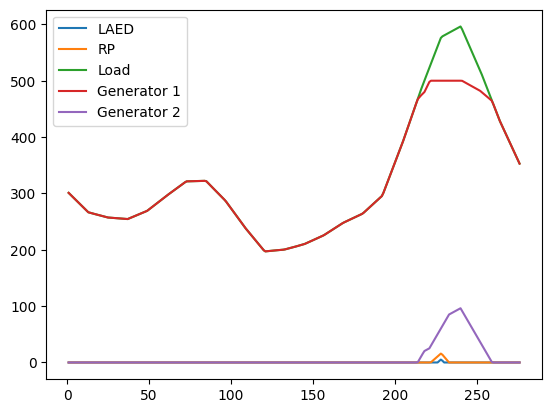

In [17]:
plt.figure()
times = np.linspace(1,len(Shed_LAED), len(Shed_LAED))
plt.plot(times, Shed_LAED, label="LAED")
plt.plot(times, Shed_ED, label="RP")
plt.plot(times, list(data.data()["Load"].values())[:len(times)], label="Load")
plt.plot(times, P_ED[0], label="Generator 1")
plt.plot(times, P_ED[1], label="Generator 2")
plt.legend()
plt.show()

In [20]:
# Print the load shedding
print('Mean Demand:', ref_cap)
print('Load Shedding in LAED:', np.sum(Shed_LAED)/12)
print('Load Shedding in ED with only', str(5*(data.data()['N_t'][None]-1)), '-min ramp product:', np.sum(Shed_ED)/12)
print('Load Shedding in ED with additional', str(5*(r_t-1)), '-min ramp product:', np.sum(Shed_ED1)/12)
print('Load Shedding in ED with additional ', str(5*(r_t-1)) + ' and ' + str(5*(r_t2-1)), '-min ramp product:', np.sum(Shed_ED2)/12)
print('Load Shedding in ED with above ramp products and extra constraints:', np.sum(Shed_ED3)/12)

Mean Demand: 325
Load Shedding in LAED: 0.8879503481683552
Load Shedding in ED with only 60 -min ramp product: 7.575325461701425
Load Shedding in ED with additional 10 -min ramp product: 5.041220102936734
Load Shedding in ED with additional  10 and 30 -min ramp product: 1.9176052073872445
Load Shedding in ED with above ramp products and extra constraints: 1.9176052073872445


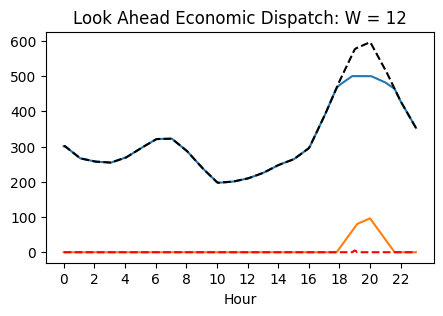

In [19]:
# LAED
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
P0 = np.array(list(data.data()['Gen_init'].values()))
load = np.array(list(data.data()['Load'].values()))

# LAED
x_range = range(0, N_T - N_t + 2)
ax.plot(x_range, np.vstack([P0, P_LAED.transpose()]))
ax.plot(x_range, np.insert(Shed_LAED, 0, 0), 'r--')
ax.plot(x_range, np.insert(load[:-(N_t-1)], 0, np.sum(P0)), 'k--')

# Set xticks at 2-hour intervals (every 24 steps)
two_hour_ticks = np.arange(0, N_T - N_t + 2, 24)
ax.set_xticks(two_hour_ticks)

# Optionally, label xticks with actual hour values
hour_labels = [str(i * 2) for i in range(len(two_hour_ticks))]
ax.set_xticklabels(hour_labels)

plt.xlabel('Hour')

plt.title('Look Ahead Economic Dispatch: W = ' + str(data.data()['N_t'][None]-1))
plt.show()

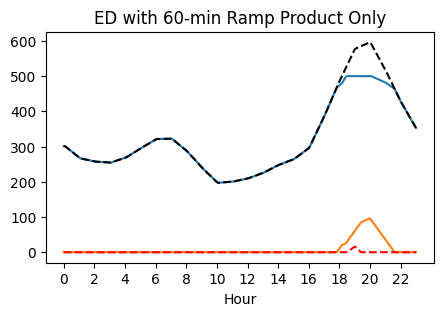

In [117]:
# ED
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)

x_range = range(0, N_T - N_t + 2)

ax.plot(x_range, np.vstack([P0, P_ED.transpose()]))
ax.plot(x_range, np.insert(Shed_ED, 0, 0), 'r--')
ax.plot(x_range, np.insert(load[:-(N_t-1)], 0, np.sum(P0)), 'k--')

# Set xticks at 2-hour intervals (every 24 steps)
two_hour_ticks = np.arange(0, N_T - N_t + 2, 24)
ax.set_xticks(two_hour_ticks)

# Optionally, label xticks with actual hour values
hour_labels = [str(i * 2) for i in range(len(two_hour_ticks))]
ax.set_xticklabels(hour_labels)

plt.xlabel('Hour')

plt.title('ED with ' + str(5*(data.data()['N_t'][None]-1)) + '-min Ramp Product Only')
plt.show()


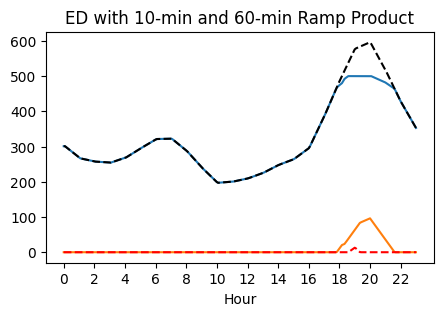

In [118]:
# ED with more ramp products
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)

x_range = range(0, N_T - N_t + 2)

ax.plot(x_range, np.vstack([P0, P_ED1.transpose()]))
ax.plot(x_range, np.insert(Shed_ED1, 0, 0), 'r--')
ax.plot(x_range, np.insert(load[:-(N_t-1)], 0, np.sum(P0)), 'k--')

# Set xticks at 2-hour intervals (every 24 steps)
two_hour_ticks = np.arange(0, N_T - N_t + 2, 24)
ax.set_xticks(two_hour_ticks)

# Optionally, label xticks with actual hour values
hour_labels = [str(i * 2) for i in range(len(two_hour_ticks))]
ax.set_xticklabels(hour_labels)

plt.xlabel('Hour')

plt.title('ED with '+ str(5*(r_t-1)) + '-min and ' + str(5*(data.data()['N_t'][None]-1)) + '-min Ramp Product')
plt.show()